##SetUp

In [ ]:
!pip install torch torchvision matplotlib

##Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torchvision.transforms.functional as TF
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [ ]:
from PIL import Image
from google.colab import drive
import os
import zipfile
import random

##Reproducibility

In [ ]:
import torch
import numpy as np
import random
import os

def set_seed(seed):
    """
    Set the seed for reproducibility.

    Args:
        seed (int): The seed value to use for random number generation.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set a seed for reproducibility
seed = 42
set_seed(seed)

##Mount Google Drive

In [ ]:
from google.colab import drive
import os
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

# Paths
drive_path = '/content/drive/My Drive/'

Mounted at /content/drive


##Extract Data

In [ ]:
import zipfile
import os
import shutil

# Unpack the dataset zip file
shutil.unpack_archive("/content/drive/MyDrive/DFUC2024.zip", "/content/Datasets/")

#Setting Environmet to group original with synthethic images

In [ ]:
pip install tensorflow keras scikit-learn

#Extracting Features

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import csv
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os

def load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def extract_features(image_paths, model):
    features = {}
    for img_path in image_paths:
        img_array = load_image(img_path)
        features[img_path] = model.predict(img_array).flatten()
    return features

# Path to save or load the model
model_path = "/content/resnet50_feature01_extractor.h5"

# Check if the model file exists
if os.path.exists(model_path):
    print("Loading existing model...")
    model = load_model(model_path)
else:
    print("Training and saving model...")
    # Load ResNet50 model pre-trained on ImageNet
    base_model = ResNet50(weights='imagenet')
    model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

    # Save the model
    model.save(model_path)
    print(f"Model saved to {model_path}")

def list_image_paths(directory):
    """ This function returns a list of full file paths from a directory for image files """
    # List comprehension to gather all jpg or png files in the directory
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.jpg', '.png'))]

# Define root path and subdirectories for synthetic and original images
root_path = "/content/Datasets/DFUC2024"
train_synthetic_dir = os.path.join(root_path, "Train/Synthetic_images")
train_original_dir = os.path.join(root_path, "Train/original_train_images")

# Get lists of image paths
synthetic_image_paths = list_image_paths(train_synthetic_dir)
original_image_paths = list_image_paths(train_original_dir)

# Extract features
original_features = extract_features(original_image_paths, model)
synthetic_features = extract_features(synthetic_image_paths, model)

# Compare Features to Group Images
def find_matches(original_features, synthetic_features):
    matches = {}
    for original_image_path, orig_feat in original_features.items():
        similarities = {synth_path: cosine_similarity(orig_feat.reshape(1, -1), synth_feat.reshape(1, -1))[0][0] for synth_path, synth_feat in synthetic_features.items()}
        best_match = max(similarities, key=similarities.get)
        matches[original_image_path] = best_match
    return matches

# Find best matches between original and synthetic images
matches = find_matches(original_features, synthetic_features)

# Save matches to a CSV file
csv_file_path = "/content/matched_images.csv"
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Original Image', 'Synthetic Image'])

    for orig_path, synth_path in matches.items():
        writer.writerow([orig_path, synth_path])

print(f"Best matched pairs saved to {csv_file_path}")

Training and saving model...
102967424/102967424 [==============================] - 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/resnet50_feature01_extractor.h5
1/1 [==============================] - 0s 82ms/step
Best matched pairs saved to /content/matched_images.csv


In [ ]:
import csv

# Load the original and synthetic image pairs from the CSV file
csv_file_path = "/content/matched_images.csv"
original_image_paths = []
synthetic_image_paths = []

with open(csv_file_path, mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header row
    for row in reader:
        original_image_path, synthetic_image_path = row
        original_image_paths.append(original_image_path)
        synthetic_image_paths.append(synthetic_image_path)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Visualize the top 5 matches
fig, axs = plt.subplots(5, 2, figsize=(10, 20))  # 5 rows for image pairs, 2 columns for original and matched synthetic

for i in range(min(5, len(original_image_paths))):
    orig_path = original_image_paths[i]
    synth_path = synthetic_image_paths[i]

    orig_img = imread(orig_path)  # Load original image
    synth_img = imread(synth_path)  # Load synthetic image

    axs[i, 0].imshow(orig_img)  # Show original image
    axs[i, 0].set_title('Original')
    axs[i, 0].axis('off')  # Hide axes

    axs[i, 1].imshow(synth_img)  # Show synthetic image
    axs[i, 1].set_title('Best Match Synthetic')
    axs[i, 1].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Preprocessing function as defined earlier
def preprocess_image(image_path, target_size=(256, 256)):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Normalize the image
    image = image / 255.0

    # Rescale the image
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_CUBIC)

    # Denoise the image using Gaussian Blur
    image = cv2.GaussianBlur(image, (5, 5), 0)

    # Convert to 8-bit image before color conversion to LAB
    image = (image * 255).astype('uint8')

    # Adjust contrast using CLAHE
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)  # Convert to LAB color space
    l, a, b = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    image = cv2.merge([l, a, b])
    image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)  # Convert back to BGR

    return image

In [14]:
import numpy as np
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_images(image_data, save_dir, image_name, rotation_range=5, width_shift_range=0.05, height_shift_range=0.05, zoom_range=0.1, fill_mode='nearest', already_normalized=False):
    """
    Augments image data with specified parameters and saves the augmented images.

    Parameters:
    - image_data: Numpy array of the image or images (3D or 4D array).
    - save_dir: Directory where augmented images will be saved.
    - image_name: Base name of the image file.
    - rotation_range: Degrees range for random rotations.
    - width_shift_range: Ranges (as a float fraction of the width) for horizontal shifts.
    - height_shift_range: Ranges (as a float fraction of the height) for vertical shifts.
    - zoom_range: Float or tuple representing the amount of zoom.
    - fill_mode: Strategy to fill newly created pixels.
    - already_normalized: Boolean indicating if the input data is already normalized to [0, 1].

    Returns:
    - A list of augmented images.
    """
    # Normalize if not already done
    if not already_normalized:
        image_data = image_data.astype('float32') / 255.0

    # Ensure image data has a batch dimension
    if image_data.ndim == 3:
        image_data = np.expand_dims(image_data, 0)

    # Create a data generator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        zoom_range=zoom_range,
        fill_mode=fill_mode
    )

    # Generate and save augmented images
    augmented_images = []
    iterator = datagen.flow(image_data, batch_size=1, save_to_dir=save_dir, save_prefix=image_name, save_format='jpg')
    for i in range(3):
        augmented_img = next(iterator)[0]
        augmented_images.append(augmented_img)
        # Save each augmented image with a unique name
        augmented_image_path = os.path.join(save_dir, f"{image_name}_aug_{i+1}.jpg")
        cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_img * 255.0, cv2.COLOR_RGB2BGR))

    return augmented_images

def preprocess_image(image_path, target_size=(256, 256)):
    """
    Preprocess the image: resize, normalize, denoise, and enhance contrast.

    Parameters:
    - image_path: Path to the image file.
    - target_size: Tuple specifying the target size for resizing.

    Returns:
    - Preprocessed image as a NumPy array.
    """
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = image / 255.0
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_CUBIC)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    image = (image * 255).astype('uint8')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    image = cv2.merge([l, a, b])
    image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)
    return image

# Define directories for saving images
preprocessed_dir = "/content/Preprocessed_Images"
augmented_dir = "/content/Augmented_Images"

os.makedirs(preprocessed_dir, exist_ok=True)
os.makedirs(augmented_dir, exist_ok=True)

# Assuming 'original_image_paths' contains paths to original images
processed_images = []
augmented_images = []

# Process and augment images
for path in original_image_paths:
    # Preprocess image
    processed_image = preprocess_image(path)
    processed_images.append(processed_image)

    # Save the preprocessed image
    image_name = os.path.basename(path).split('.')[0]  # Get base name without extension
    preprocessed_image_path = os.path.join(preprocessed_dir, f"{image_name}_preprocessed.jpg")
    cv2.imwrite(preprocessed_image_path, cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))

    # Augment the image and save
    aug_images = augment_images(np.expand_dims(processed_image, axis=0), augmented_dir, image_name)
    augmented_images.extend(aug_images)

print(f"Preprocessed images saved to {preprocessed_dir}")
print(f"Augmented images saved to {augmented_dir}")

Preprocessed images saved to /content/Preprocessed_Images
Augmented images saved to /content/Augmented_Images


##FOr Validation

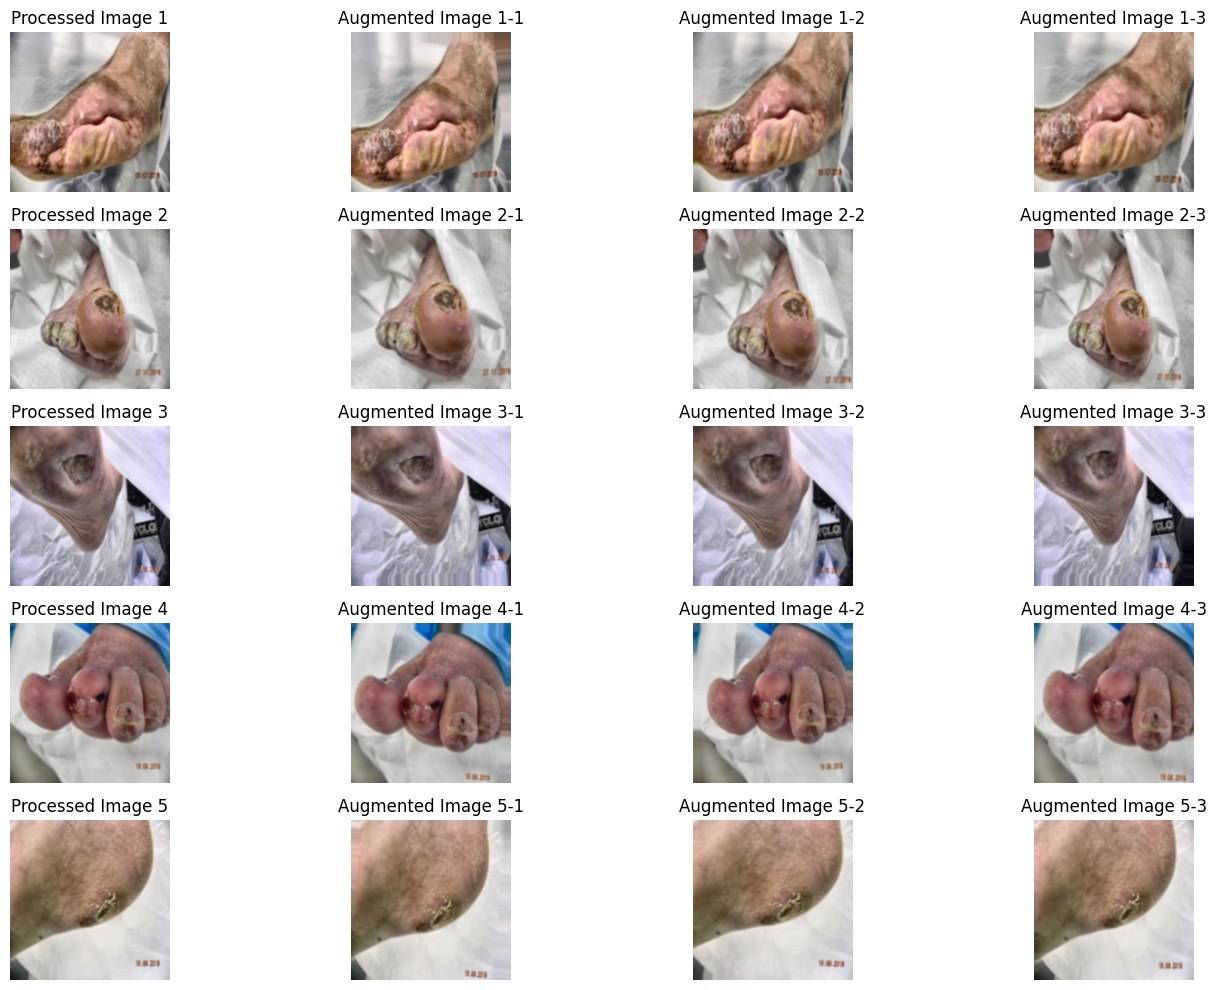

In [15]:
import matplotlib.pyplot as plt
import cv2

# Determine the number of images to display (maximum of 5)
num_images_to_display = min(5, len(processed_images))

# Visualization setup
fig, axs = plt.subplots(num_images_to_display, 4, figsize=(15, 10))  # Adjusted for dynamic number of rows

for i in range(num_images_to_display):
    proc_img = processed_images[i]
    aug_imgs = augmented_images[i*3:(i+1)*3]  # Each image has 3 augmentations

    axs[i, 0].imshow(cv2.cvtColor(proc_img, cv2.COLOR_BGR2RGB))
    axs[i, 0].set_title('Processed Image {}'.format(i+1))
    axs[i, 0].axis('off')

    for j, aug_img in enumerate(aug_imgs):
        axs[i, j+1].imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
        axs[i, j+1].set_title('Augmented Image {}-{}'.format(i+1, j+1))
        axs[i, j+1].axis('off')

plt.tight_layout()
plt.show()

In [17]:
# Define directories for saving images
preprocessed_dir = "/content/Preprocessed_synthetic_Images"
augmented_dir = "/content/Augmented_synthetic_Images"

os.makedirs(preprocessed_dir, exist_ok=True)
os.makedirs(augmented_dir, exist_ok=True)

# Assuming 'synthetic_image_paths' contains paths to synthetic images
processed_synthetic_images = []
augmented_synthetic_images = []

# Process and augment synthetic images
for path in synthetic_image_paths:
    # Preprocess the synthetic image
    processed_image = preprocess_image(path)
    processed_synthetic_images.append(processed_image)

    # Save the preprocessed synthetic image
    image_name = os.path.basename(path).split('.')[0]  # Get base name without extension
    preprocessed_image_path = os.path.join(preprocessed_dir, f"{image_name}_preprocessed.jpg")
    cv2.imwrite(preprocessed_image_path, cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))

    # Augment the synthetic image and save
    aug_images = augment_images(np.expand_dims(processed_image, axis=0), augmented_dir, image_name)
    augmented_synthetic_images.extend(aug_images)

print(f"Preprocessed synthetic images saved to {preprocessed_dir}")
print(f"Augmented synthetic images saved to {augmented_dir}")

Preprocessed synthetic images saved to /content/Preprocessed_synthetic_Images
Augmented synthetic images saved to /content/Augmented_synthetic_Images


In [19]:
import matplotlib.pyplot as plt
import cv2

# Limit to 8 images for display
num_images_to_display = min(8, len(processed_images))

# Adjust the number of columns to 8 to accommodate all images
fig, axs = plt.subplots(num_images_to_display, 8, figsize=(24, 10))

for i in range(num_images_to_display):
    proc_orig_img = processed_images[i]
    aug_orig_imgs = augmented_images[i*3:(i+1)*3]  # Assuming 3 augmentations per image
    proc_synth_img = processed_synthetic_images[i]
    aug_synth_imgs = augmented_synthetic_images[i*3:(i+1)*3]  # Assuming 3 augmentations per image

    # Show processed original image
    axs[i, 0].imshow(cv2.cvtColor(proc_orig_img, cv2.COLOR_BGR2RGB))
    axs[i, 0].set_title('Processed Original Image {}'.format(i+1))
    axs[i, 0].axis('off')

    # Show augmented original images
    for j, aug_img in enumerate(aug_orig_imgs):
        axs[i, j+1].imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
        axs[i, j+1].set_title('Aug. Orig. Image {}-{}'.format(i+1, j+1))
        axs[i, j+1].axis('off')

    # Show processed synthetic image
    axs[i, 4].imshow(cv2.cvtColor(proc_synth_img, cv2.COLOR_BGR2RGB))
    axs[i, 4].set_title('Processed Synthetic Image {}'.format(i+1))
    axs[i, 4].axis('off')

    # Show augmented synthetic images
    for k, aug_img in enumerate(aug_synth_imgs):
        axs[i, k+5].imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))  # Adjust index to fit within the new grid
        axs[i, k+5].set_title('Aug. Synth. Image {}-{}'.format(i+1, k+1))
        axs[i, k+5].axis('off')

plt.tight_layout()
plt.show()

#Self-Supervised Learning Framework

In [20]:
import numpy as np

# Assuming processed_images and processed_synthetic_images are lists of individual image arrays
processed_images_np = np.array(processed_images)
processed_synthetic_images_np = np.array(processed_synthetic_images)

# Reshape augmented_images to match the processed_images
# Assuming 3 augmentations per image
augmented_images_grouped = [augmented_images[i*3:(i+1)*3] for i in range(len(processed_images))]
augmented_synthetic_images_grouped = [augmented_synthetic_images[i*3:(i+1)*3] for i in range(len(processed_synthetic_images))]

# Convert to NumPy arrays
augmented_images_np = np.array(augmented_images_grouped)
augmented_synthetic_images_np = np.array(augmented_synthetic_images_grouped)


In [22]:
processed_images_np = processed_images_np.astype('float32') / 255.0

In [25]:
processed_synthetic_images_np = processed_synthetic_images_np.astype('float32') / 255.0

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

def build_autoencoder(input_shape=(256, 256, 3)):
    # Encoder
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2))(x)

    # Transformation Layer
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    # Decoder
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Model
    autoencoder = models.Model(inputs, decoded)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error')

    return autoencoder

# Initialize the model
autoencoder = build_autoencoder()

# Prepare your image data
# Assuming processed_images_np and processed_synthetic_images_np are already prepared as NumPy arrays
all_images = np.concatenate((processed_images_np, processed_synthetic_images_np), axis=0)

# Define callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_autoencoder.h5', monitor='val_loss', save_best_only=True, save_weights_only=False)

# Train the autoencoder with early stopping and model checkpointing
autoencoder.fit(
    all_images,
    all_images,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/50
113/113 [==============================] - 329s 3s/step - loss: 0.0174 - val_loss: 0.0032
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


113/113 [==============================] - 326s 3s/step - loss: 0.0023 - val_loss: 0.0015
Epoch 3/50
113/113 [==============================] - 327s 3s/step - loss: 0.0014 - val_loss: 0.0010
Epoch 4/50
113/113 [==============================] - 327s 3s/step - loss: 0.0011 - val_loss: 8.1653e-04
Epoch 5/50
113/113 [==============================] - 326s 3s/step - loss: 8.6883e-04 - val_loss: 6.5812e-04
Epoch 6/50
113/113 [==============================] - 327s 3s/step - loss: 7.2800e-04 - val_loss: 5.6008e-04
Epoch 7/50
113/113 [==============================] - 327s 3s/step - loss: 6.4566e-04 - val_loss: 5.0356e-04
Epoch 8/50
113/113 [==============================] - 327s 3s/step - loss: 5.6362e-04 - val_loss: 4.9633e-04
Epoch 9/50
113/113 [==============================] - 328s 3s/step - loss: 5.3636e-04 - val_loss: 4.4173e-04
Epoch 10/50
113/113 [==============================] - 328s 3s/step - loss: 4.7867e-04 - val_loss: 4.0396e-04
Epoch 11/50
113/113 [============================

#Visualising Prediction

1/1 [==============================] - 0s 164ms/step


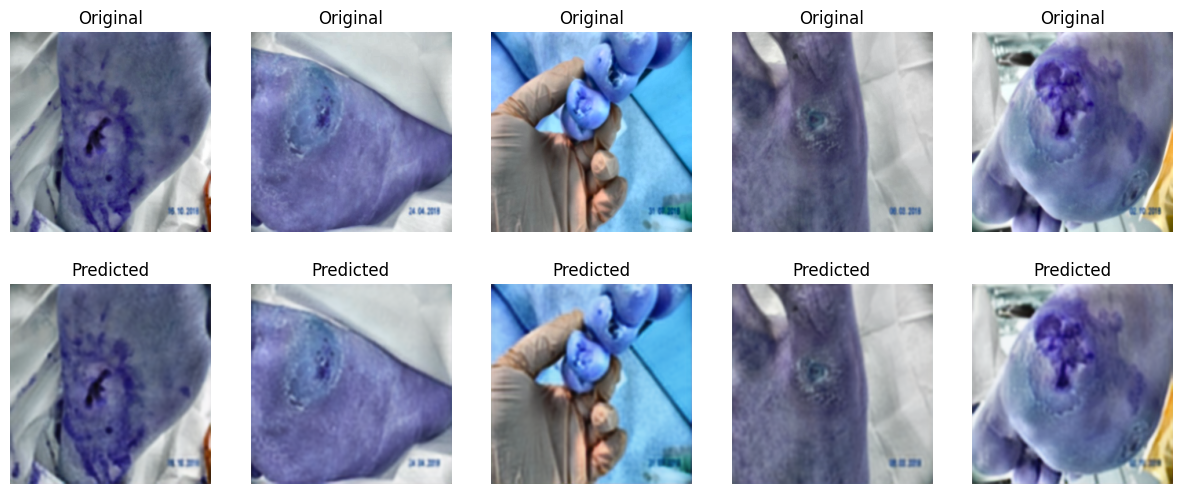

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Select random samples from the processed images
sample_indexes = np.random.choice(range(len(processed_images_np)), 5, replace=False)
sample_images = processed_images_np[sample_indexes]

# Generate predictions using the autoencoder
predictions = autoencoder.predict(sample_images)

# Create subplots for visualization
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, (original, prediction) in enumerate(zip(sample_images, predictions)):
    # Display the original image
    axes[0, i].imshow(original)
    axes[0, i].axis('off')
    axes[0, i].set_title('Original')

    # Display the predicted (reconstructed) image
    axes[1, i].imshow(prediction)
    axes[1, i].axis('off')
    axes[1, i].set_title('Predicted')

plt.show()

Found 200 files belonging to 1 classes.
1/1 [==============================] - 0s 127ms/step


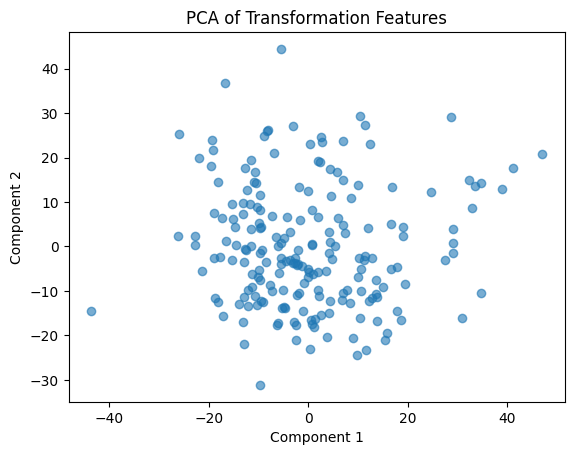

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


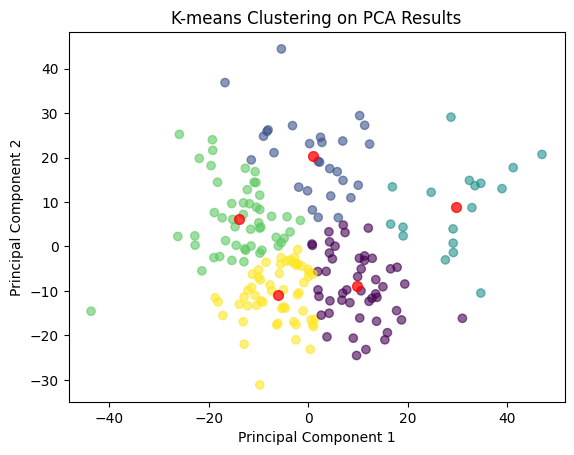

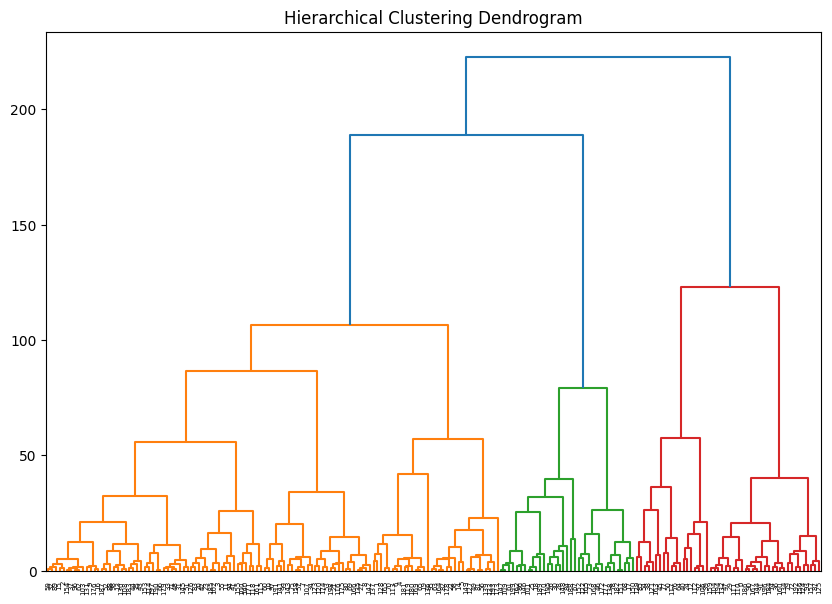

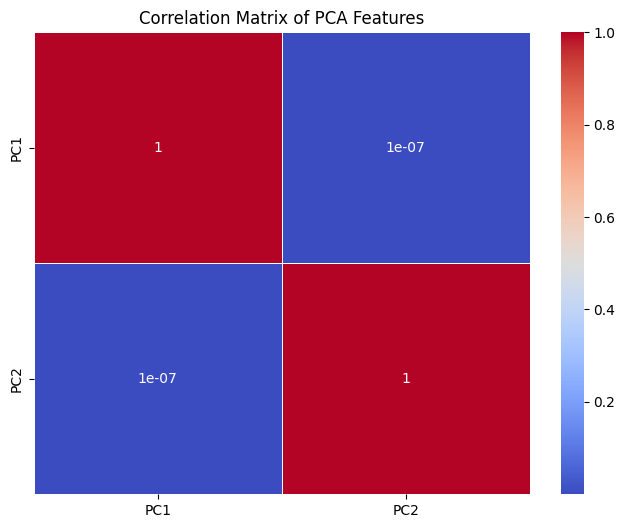

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
import os

# Define and preprocess the validation dataset
def preprocess_images(image_directory, batch_size=32, image_size=(256, 256)):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        image_directory,
        image_size=image_size,
        batch_size=batch_size,
        label_mode=None  # Assuming you don't need labels
    )
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    dataset = dataset.map(lambda x: normalization_layer(x))
    return dataset

# Assuming you have a directory '/content/Datasets/DFUC2024/Validation' with validation images
validation_dataset = preprocess_images('/content/Datasets/DFUC2024/validation')

# Extract features from a specific layer of the model
def extract_features(model, layer_name, dataset):
    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=model.get_layer(layer_name).output)
    features = []
    for input_img in dataset:
        intermediate_output = intermediate_layer_model.predict(input_img)
        features.append(intermediate_output)
    return np.vstack(features)  # Combine all features into a single array

# Flattening the features for PCA and clustering
def flatten_features(features):
    return features.reshape(features.shape[0], -1)

# Perform PCA and visualize the results
def perform_pca_and_visualize(features):
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(flatten_features(features))

    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], alpha=0.6)
    plt.title('PCA of Transformation Features')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

    return reduced_features

# Perform K-Means clustering and visualize the clusters
def perform_kmeans_and_visualize(reduced_features, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    clusters = kmeans.fit_predict(reduced_features)

    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', alpha=0.6)
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.75)  # Cluster centers
    plt.title('K-means Clustering on PCA Results')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Perform hierarchical clustering and visualize with a dendrogram
def perform_hierarchical_clustering(reduced_features):
    linked = linkage(reduced_features, method='ward')
    plt.figure(figsize=(10, 7))
    dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.show()

# Analyze and visualize the correlation matrix of PCA features
def analyze_correlation_matrix(reduced_features):
    features_df = pd.DataFrame(reduced_features, columns=['PC1', 'PC2'])
    correlation_matrix = features_df.corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix of PCA Features')
    plt.show()

# Main workflow
if __name__ == "__main__":
    # Assuming `autoencoder` is already defined and trained
    # Extract features from a specific layer
    layer_name = 'conv2d_22'  # Use the correct layer name from your model
    transformation_features = extract_features(autoencoder, layer_name, validation_dataset)

    # Perform PCA and visualize
    reduced_features = perform_pca_and_visualize(transformation_features)

    # Perform K-Means clustering and visualize the clusters
    perform_kmeans_and_visualize(reduced_features, n_clusters=5)

    # Perform hierarchical clustering and visualize with a dendrogram
    perform_hierarchical_clustering(reduced_features)

    # Analyze and visualize the correlation matrix of PCA features
    analyze_correlation_matrix(reduced_features)

#Generating Synthetic Test Dataset

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt

# Preprocess the images (rescale and resize)
def preprocess_images(dataset):
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    resize_layer = tf.keras.layers.Resizing(256, 256)

    # Apply the preprocessing steps to the dataset
    dataset = dataset.map(lambda x: resize_layer(normalization_layer(x)))
    return dataset

# Load images from the Test directory into a preprocessed dataset
def load_images(image_directory):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        image_directory,
        image_size=(256, 256),  # Resize images to 256x256 pixels
        batch_size=32,
        label_mode=None  # No labels needed
    )
    return preprocess_images(dataset)

# Load the trained autoencoder model
autoencoder = load_model('best_autoencoder.h5')

# Load and preprocess the Test dataset
test_dataset = load_images('/content/Datasets/DFUC2024/Test')

# Generate synthetic images using the trained autoencoder
predicted_synthetic_images = autoencoder.predict(test_dataset)

# Save the generated synthetic images
def save_images(images, directory='/content/Datasets/DFUC2024/Test/synthetic_images'):
    os.makedirs(directory, exist_ok=True)
    for i, img in enumerate(images):
        img_path = os.path.join(directory, f'synthetic_image_{i}.png')
        plt.imsave(img_path, img)

# Call the function to save the synthetic images
save_images(predicted_synthetic_images)

Found 2000 files belonging to 1 classes.


63/63 [==============================] - 27s 416ms/step


In [37]:
import os
import shutil

# Define the source directory where all images are currently stored
source_dir = '/content/Datasets/DFUC2024/Test'

# Define target directories for synthetic and real images
synthetic_dir = os.path.join(source_dir, 'synthetic_images')
real_dir = os.path.join(source_dir, 'real_images')

# Create target directories if they do not exist
os.makedirs(synthetic_dir, exist_ok=True)
os.makedirs(real_dir, exist_ok=True)

# Iterate through all files in the source directory
for filename in os.listdir(source_dir):
    file_path = os.path.join(source_dir, filename)

    # Check if the file is a synthetic image based on the naming pattern
    if filename.startswith('synthetic_image_') and filename.endswith('.png'):
        # Move the synthetic image to the synthetic_images directory
        shutil.move(file_path, os.path.join(synthetic_dir, filename))
    elif filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg'):
        # Move real images to the real_images directory
        shutil.move(file_path, os.path.join(real_dir, filename))

print("Images have been separated into 'synthetic_images' and 'real_images' folders.")

Images have been separated into 'synthetic_images' and 'real_images' folders.


In [38]:
import os

def count_images_in_folder(folder_path):
    # Count the number of files in the folder
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

# Define the paths to the synthetic and real image folders
synthetic_dir = '/content/Datasets/DFUC2024/Test/synthetic_images'
real_dir = '/content/Datasets/DFUC2024/Test/real_images'

# Count the number of images in each folder
num_synthetic_images = count_images_in_folder(synthetic_dir)
num_real_images = count_images_in_folder(real_dir)

# Print the results
print(f"Number of synthetic images: {num_synthetic_images}")
print(f"Number of real images: {num_real_images}")

Number of synthetic images: 2000
Number of real images: 2000


#Merging all images in preparation for training

In [39]:
import os
import numpy as np
import tensorflow as tf
import shutil
import matplotlib.pyplot as plt

# Preprocess the images (rescale and resize)
def preprocess_images(dataset):
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    resize_layer = tf.keras.layers.Resizing(256, 256)

    # Apply the preprocessing steps to the dataset
    dataset = dataset.map(lambda x: resize_layer(normalization_layer(x)))
    return dataset

# Load images from a directory into a preprocessed dataset
def load_images(image_directory):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        image_directory,
        image_size=(256, 256),  # Resize images to 256x256 pixels
        batch_size=32,
        label_mode=None  # No labels needed
    )
    return preprocess_images(dataset)

# Save preprocessed images into a single folder
def save_images(dataset, target_directory):
    os.makedirs(target_directory, exist_ok=True)
    for i, img in enumerate(dataset.unbatch().as_numpy_iterator()):
        img_path = os.path.join(target_directory, f'preprocessed_image_{i}.png')
        plt.imsave(img_path, img)

# Define source directories
train_original_dir = '/content/Datasets/DFUC2024/Train/original_train_images'
train_synthetic_dir = '/content/Datasets/DFUC2024/Train/Synthetic_images'
test_synthetic_dir = '/content/Datasets/DFUC2024/Test/synthetic_images'

# Define target directory
target_directory = '/content/Datasets/DFUC2024/preprocessed_images'

# Load, preprocess, and save all images into the target directory
train_original_dataset = load_images(train_original_dir)
save_images(train_original_dataset, target_directory)

train_synthetic_dataset = load_images(train_synthetic_dir)
save_images(train_synthetic_dataset, target_directory)

test_synthetic_dataset = load_images(test_synthetic_dir)
save_images(test_synthetic_dataset, target_directory)

print(f"All preprocessed images have been saved to {target_directory}.")

Found 2000 files belonging to 1 classes.
Found 2000 files belonging to 1 classes.
Found 2000 files belonging to 1 classes.
All preprocessed images have been saved to /content/Datasets/DFUC2024/preprocessed_images.


In [44]:
import os
import shutil

# Define source directories
source_directories = [
    '/content/Datasets/DFUC2024/Train/original_train_images',
    '/content/Datasets/DFUC2024/Train/Synthetic_images',
    '/content/Datasets/DFUC2024/Test/synthetic_images'
]

# Define target directory
target_directory = '/content/Datasets/DFUC2024/combined_images'

# Create the target directory if it doesn't exist
os.makedirs(target_directory, exist_ok=True)

# Move images from all source directories to the target directory
img_counter = 0
for source_dir in source_directories:
    for filename in os.listdir(source_dir):
        source_path = os.path.join(source_dir, filename)
        target_path = os.path.join(target_directory, filename)

        if os.path.isfile(source_path):
            shutil.move(source_path, target_path)
            img_counter += 1

print(f"All images have been moved to {target_directory}. Total images moved: {img_counter}")

All images have been moved to /content/Datasets/DFUC2024/combined_images. Total images moved: 6000


#Making existing model more robust by training on combined dataset

In [45]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Load the existing pre-trained model
existing_model_path = 'best_autoencoder.h5'  # Path to your previously trained model
autoencoder = load_model(existing_model_path)

# Load preprocessed images from the directory
def load_preprocessed_images(image_directory, image_size=(256, 256), batch_size=32):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        image_directory,
        image_size=image_size,
        batch_size=batch_size,
        label_mode=None  # No labels needed
    )
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    dataset = dataset.map(lambda x: normalization_layer(x))
    return dataset

# Example usage: Load dataset from the combined folder
combined_dataset = load_preprocessed_images('/content/Datasets/DFUC2024/combined_images')

# Map the dataset to create (input, output) pairs where output is identical to input
combined_dataset = combined_dataset.map(lambda x: (x, x))

# Ensure the dataset is batched, shuffled, and prefetched for performance
combined_dataset = combined_dataset.shuffle(buffer_size=1024).prefetch(tf.data.AUTOTUNE)

# Load and prepare the validation dataset in the same way
validation_dataset = load_preprocessed_images('/content/Datasets/DFUC2024/validation')
validation_dataset = validation_dataset.map(lambda x: (x, x)).prefetch(tf.data.AUTOTUNE)

# Define callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_autoencoder_segmentation.h5', monitor='val_loss', save_best_only=True, save_weights_only=False)

# Continue training the existing autoencoder model on all combined images
autoencoder.fit(
    combined_dataset,
    epochs=5,
    validation_data=validation_dataset,  # Use the validation dataset here
    callbacks=[early_stopping, model_checkpoint]
)

# Save the final model
autoencoder.save('robust_autoencoder_model.h5')

Found 6000 files belonging to 1 classes.
Found 200 files belonging to 1 classes.
Epoch 1/5
188/188 [==============================] - 548s 3s/step - loss: 2.8663e-04 - val_loss: 4.2141e-04
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


188/188 [==============================] - 539s 3s/step - loss: 2.5227e-04 - val_loss: 4.3264e-04
Epoch 3/5
188/188 [==============================] - 545s 3s/step - loss: 2.5048e-04 - val_loss: 4.0837e-04
Epoch 4/5
188/188 [==============================] - 543s 3s/step - loss: 2.4417e-04 - val_loss: 4.1379e-04
Epoch 5/5
188/188 [==============================] - 545s 3s/step - loss: 2.4530e-04 - val_loss: 3.9884e-04


#Final Prediction

In [47]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import os
import pandas as pd

# Load the pre-trained robust model
model = load_model('robust_autoencoder_model.h5')

# Load and preprocess the test images
def preprocess_images(image_directory):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        image_directory,
        image_size=(256, 256),
        batch_size=1,  # Process images one at a time
        label_mode=None  # No labels needed
    )
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    dataset = dataset.map(lambda x: normalization_layer(x))
    return dataset

test_dataset = preprocess_images('/content/Datasets/DFUC2024/Test/real_images')

# Function to generate synthetic ground truth contours
def generate_synthetic_ground_truth(image_shape):
    # Create a synthetic ground truth mask (e.g., a circle or any other shape)
    ground_truth = np.zeros(image_shape, dtype=np.uint8)
    center = (image_shape[1] // 2, image_shape[0] // 2)  # Center of the image
    radius = min(image_shape[0], image_shape[1]) // 4  # Radius of the circle
    cv2.circle(ground_truth, center, radius, 1, thickness=cv2.FILLED)
    return ground_truth

# Prepare a list to store the CSV data
csv_data = []

# Perform segmentation, extract contours, generate synthetic ground truth, and save the results
for i, img_batch in enumerate(test_dataset):
    # Predict segmentation mask
    pred_mask = model.predict(img_batch)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Binarize the output mask

    # Ensure the mask is single-channel (CV_8UC1)
    if len(pred_mask.shape) > 2:
        pred_mask = cv2.cvtColor(pred_mask, cv2.COLOR_BGR2GRAY)

    # Extract contours from the predicted mask
    contours, _ = cv2.findContours(pred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pred_contour = np.zeros_like(pred_mask)
    cv2.drawContours(pred_contour, contours, -1, (1), thickness=cv2.FILLED)

    # Generate synthetic ground truth contour
    true_contour = generate_synthetic_ground_truth(pred_mask.shape)

    # Store the predicted and ground truth contours as space-separated strings in the CSV data list
    csv_row = {
        'id': i,
        'X': ' '.join(map(str, pred_contour.flatten())),  # Predicted contour as a space-separated string
        'Y': ' '.join(map(str, true_contour.flatten()))  # Generated synthetic ground truth contour as a space-separated string
    }
    csv_data.append(csv_row)

# Create a DataFrame and save to CSV
df = pd.DataFrame(csv_data, columns=['id', 'X', 'Y'])
df.to_csv('/content/Datasets/DFUC2024/segmentation_results.csv', index=False)

print("Predicted contours and generated synthetic ground truth saved to CSV.")

Found 2000 files belonging to 1 classes.
1/1 [==============================] - 0s 46ms/step
Predicted contours and generated synthetic ground truth saved to CSV.


In [48]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

# Load the pre-trained robust model
model = load_model('robust_autoencoder_model.h5')

# Load and preprocess the test images
def preprocess_images(image_directory):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        image_directory,
        image_size=(256, 256),
        batch_size=1,  # Process images one at a time
        label_mode=None  # No labels needed
    )
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    dataset = dataset.map(lambda x: normalization_layer(x))
    return dataset

test_dataset = preprocess_images('/content/Datasets/DFUC2024/Test/real_images')

# Prepare output directories
output_mask_dir = '/content/Datasets/DFUC2024/segmentation_masks22'
os.makedirs(output_mask_dir, exist_ok=True)

# Function to generate synthetic ground truth contours
def generate_synthetic_ground_truth(image_shape):
    ground_truth = np.zeros(image_shape, dtype=np.uint8)
    center = (image_shape[1] // 2, image_shape[0] // 2)  # Center of the image
    radius = min(image_shape[0], image_shape[1]) // 4  # Radius of the circle
    cv2.circle(ground_truth, center, radius, 1, thickness=cv2.FILLED)
    return ground_truth

# Function to calculate DSC, IoU, FNE, and FPE
def calculate_metrics(pred_mask, true_mask):
    pred_mask = pred_mask.flatten()
    true_mask = true_mask.flatten()

    intersection = np.sum(pred_mask * true_mask)
    union = np.sum(pred_mask) + np.sum(true_mask)

    dsc = 2 * intersection / union if union != 0 else 1.0
    iou = intersection / (union - intersection) if (union - intersection) != 0 else 1.0
    fne = np.sum(true_mask * (1 - pred_mask)) / np.sum(true_mask) if np.sum(true_mask) != 0 else 0.0
    fpe = np.sum(pred_mask * (1 - true_mask)) / np.sum(1 - true_mask) if np.sum(1 - true_mask) != 0 else 0.0

    return dsc, iou, fne, fpe

# Prepare a list to store the CSV data
csv_data = []

# Perform segmentation, extract contours, save masks, and store results
for i, img_batch in enumerate(test_dataset):
    # Predict segmentation mask
    pred_mask = model.predict(img_batch)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Binarize the output mask (0 for background, 1 for ulcer region)

    # Ensure the mask is single-channel (CV_8UC1)
    if len(pred_mask.shape) > 2:
        pred_mask = cv2.cvtColor(pred_mask, cv2.COLOR_BGR2GRAY)

    # Save the binary mask image
    mask_filename = f'mask_image_{i}.png'
    mask_filepath = os.path.join(output_mask_dir, mask_filename)
    plt.imsave(mask_filepath, pred_mask.squeeze(), cmap='gray')

    # Generate synthetic ground truth contour
    true_contour = generate_synthetic_ground_truth(pred_mask.shape)

    # Calculate the metrics
    dsc, iou, fne, fpe = calculate_metrics(pred_mask, true_contour)

    # Store the results in the CSV data list
    csv_row = {
        'id': i,
        'X': ' '.join(map(str, pred_mask.flatten())),  # Predicted contour as a space-separated string
        'Y': ' '.join(map(str, true_contour.flatten())),  # Ground truth contour as a space-separated string
        'DSC': dsc,
        'IoU': iou,
        'FNE': fne,
        'FPE': fpe
    }
    csv_data.append(csv_row)

# Create a DataFrame and save to CSV
df = pd.DataFrame(csv_data, columns=['id', 'X', 'Y', 'DSC', 'IoU', 'FNE', 'FPE'])
df.to_csv('/content/Datasets/DFUC2024/segmentation_results22.csv', index=False)

print(f"Segmentation results and mask images have been saved to {output_mask_dir} and the CSV file.")

Found 2000 files belonging to 1 classes.
1/1 [==============================] - 0s 42ms/step
Segmentation results and mask images have been saved to /content/Datasets/DFUC2024/segmentation_masks22 and the CSV file.


In [49]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import os

# Load the pre-trained robust model
model = load_model('robust_autoencoder_model.h5')

# Load and preprocess the test images
def preprocess_images(image_directory):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        image_directory,
        image_size=(256, 256),
        batch_size=1,  # Process images one at a time
        label_mode=None  # No labels needed
    )
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    dataset = dataset.map(lambda x: normalization_layer(x))
    return dataset

test_dataset = preprocess_images('/content/Datasets/DFUC2024/Test/real_images')

# Prepare output directories
output_mask_dir = '/content/Datasets/DFUC2024/the_segmentation_masks'
os.makedirs(output_mask_dir, exist_ok=True)

# Function to save mask images with the image ID as the filename
def save_mask_image(pred_mask, image_id, output_dir):
    # Ensure the mask is single-channel (CV_8UC1)
    if len(pred_mask.shape) > 2:
        pred_mask = cv2.cvtColor(pred_mask, cv2.COLOR_BGR2GRAY)

    # Binarize the mask (set pixel-wise label for background (0) and ulcer region (1))
    pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255  # Convert to 0 and 255 for saving as image

    # Save the mask image with the image ID as the filename
    mask_filename = f'{image_id}.png'
    mask_filepath = os.path.join(output_dir, mask_filename)
    cv2.imwrite(mask_filepath, pred_mask)

# Perform segmentation and save masks with the correct naming convention
for i, img_batch in enumerate(test_dataset):
    # Predict segmentation mask
    pred_mask = model.predict(img_batch)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Binarize the output mask

    # Save the mask image with the image ID as the filename
    save_mask_image(pred_mask, i, output_mask_dir)

print(f"Mask images have been saved to {output_mask_dir}.")

Found 2000 files belonging to 1 classes.
1/1 [==============================] - 0s 42ms/step
Mask images have been saved to /content/Datasets/DFUC2024/the_segmentation_masks.
